In [47]:
import timm
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import pandas as pd
from torchvision.transforms import ToTensor
from PIL import Image
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size=1
image_count=25
tf = ToTensor()


In [48]:
class Custom_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = timm.create_model('resnet34', pretrained=True)
        self.hidden_size = 128
        self.num_layers = 4
        self.rnn = nn.RNN(1000, 128, 4, batch_first=True)
        self.fc = nn.Linear(128, 2)
        self.cfs = nn.Linear(2, 1000)
        self.cfa = nn.Linear(1, 1000)
        self.fc1 = nn.Linear(1000, 1)
        self.fc5 = nn.Linear(4, 2)

    def forward(self, inputs, sex, age):
        total_x = torch.empty((batch_size, image_count, 1)).to(device)
        final_x = torch.empty((batch_size, 1)).to(device)
        for i in range(len(inputs)):
            for j in range(len(inputs[i])):
                x = self.cnn1(inputs[i, j].to(device))
                x = self.fc1(x).to(device)
                total_x[i, j] = x.to(device)
            total_x[i], indices = torch.sort(total_x[i], dim=1)
            final_x[i] = total_x[i, -1].to(device)

        x = torch.cat([final_x, sex], dim=1).to(device)
        x = torch.cat([x, age], dim=1).to(device)
        x = self.fc5(x)
        return x


class CustomDataset(Dataset):
    def __init__(self, image_list, sex, age, label):
        self.img_path = image_list

        self.label = label
        self.sex = sex
        self.age = age

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image_tensor = self.img_path[idx]
        clinical_tensor = self.sex[idx]
        clinical_age_tensor = self.age[idx]
        label_tensor = F.one_hot(self.label[idx].to(torch.int64),num_classes=2)
        return (image_tensor, clinical_tensor, clinical_age_tensor), label_tensor


In [58]:


image_transition_path = '../../data/ensemble_tile/CN/test/transition/5x/*'
image_not_transition_path = '../../data/ensemble_tile/CN/test/not_transition/5x/*'
csv = pd.read_csv('../../data/2023_dataton_age_sex_validation.csv',encoding='cp949')

image_list = []
label_list = []
image_transition_list = glob(image_transition_path)
image_transition_label = torch.ones(len(image_transition_list), 1)
image_not_transition_list = glob(image_not_transition_path)
image_not_transition_label = torch.zeros(len(image_not_transition_list), 1)
image_list.extend(image_transition_list)
image_list.extend(image_not_transition_list)
label_list.extend(image_transition_label)
label_list.extend(image_not_transition_label)


image_5x_tensor = torch.empty((len(image_list), image_count, 1, 3, 256, 256))


clinical_tensor = torch.zeros((len(image_list), 2))
clinical_age_tensor = torch.zeros((len(image_list), 1))
for i in range(len(image_list)):
    image_file_list = glob(image_list[i]+'/*.jpg')
    image_index = torch.randint(low=0, high=len(
        image_file_list)-1, size=(image_count,))
    count = 0
    for index in image_index:
        image = 1 - \
            tf(Image.open(image_file_list[index]).resize(
                (256, 256))).unsqueeze(0)
        image_5x_tensor[i, count] = image.unsqueeze(0)
        count += 1

    clincal_feature = csv.loc[csv['데이터톤번호'] ==
                              os.path.basename(image_list[i])].reset_index()
    clinical_age_tensor[i, 0] = clincal_feature.loc[0]['나이']/100
    if clincal_feature.loc[0]['성별'] == 'Female':
        clinical_tensor[i, 1] = 1
    else:
        clinical_tensor[i, 0] = 1


dataset = CustomDataset(image_5x_tensor, clinical_tensor,
                        clinical_age_tensor, label_list)


dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, drop_last=True)

model = Custom_model()
model = model.to(device)
model.load_state_dict(torch.load(
    '../../model/image_5x/full_Nonrelu_CN_tile50_RNN_3.pt'))

<All keys matched successfully>

In [83]:

total_y = torch.zeros((len(dataloader), 2)).to(device)
total_prob = torch.zeros((len(dataloader), 2)).to(device)
count = 0
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
for x, y in dataloader:
    y = y.to(device).float()
    x[0] = x[0].to(device).float()
    x[1] = x[1].to(device).float()
    x[2] = x[2].to(device).float()
    optimizer.zero_grad()
    predict = model(x[0], x[1], x[2]).to(device)
    cost = F.cross_entropy(predict.softmax(dim=1), y.squeeze(dim=1))
    cost.backward() # cost에 대한 backward 구함
    optimizer.step() 
    prob_pred = predict.softmax(dim=1)
    total_y[count] = y.squeeze(dim=1)
    total_prob[count] = prob_pred
    count += 1


In [84]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
fpr1, tpr1, cut1 = roc_curve(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1))
test_score=roc_auc_score(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1))

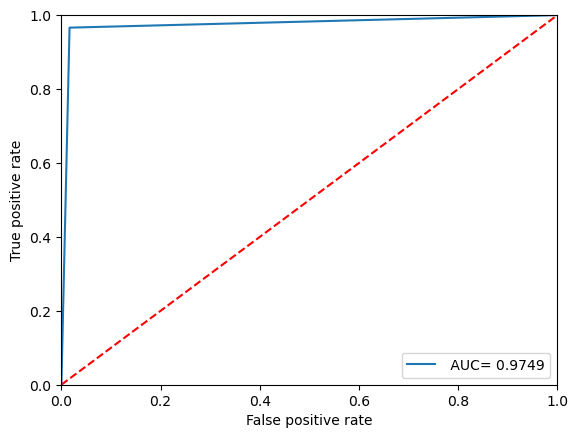

In [85]:
import matplotlib.pyplot as plt
plt.plot(fpr1, tpr1, label=' AUC= %.4f'%test_score )
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])      # X축의 범위: [xmin, xmplt]
plt.ylim([0, 1])     # Y축의 범위: [ymin, ymplt]
plt.xlabel('False positive rate')      # X축의 범위: [xmin, xmplt]
plt.ylabel('True positive rate')
plt.legend()
plt.show()

Threshholds= 0.0 f1-score=0.7889908256880733
              precision    recall  f1-score   support

      Non-AF       0.77      0.89      0.82        61
          AF       0.86      0.73      0.79        59

    accuracy                           0.81       120
   macro avg       0.82      0.81      0.81       120
weighted avg       0.81      0.81      0.81       120



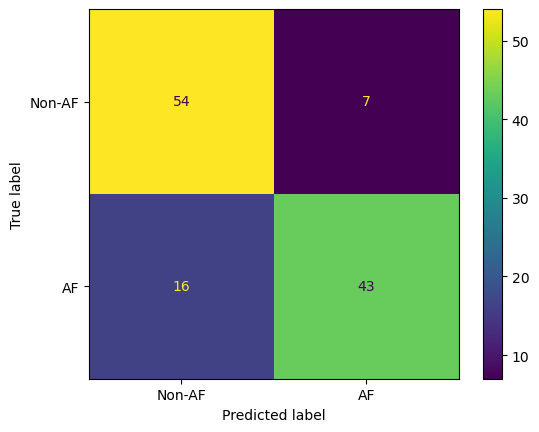

In [73]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from copy import copy
import numpy as np
a=np.linspace(0.0000,1.000,1001)
report1=0
tresh_hold=0.000
for i in a:
    t_prob=np.where(total_prob.cpu().argmax(axis=1)>i,1,0)
    report = f1_score(total_y.cpu().argmax(axis=1),t_prob)
    if report1<report:
        tresh_hold=copy(i)
        report1=copy(report)
print(f"Threshholds= {tresh_hold} f1-score={report1}")
classes = ['Non-AF','AF']
t_prob=np.where(total_prob.cpu().argmax(axis=1)>tresh_hold,1,0)
report = classification_report(total_y.cpu().argmax(axis=1), t_prob, target_names=classes)
cm = confusion_matrix(total_y.cpu().argmax(axis=1), t_prob)
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()

print(report)

f1score=0.82142857


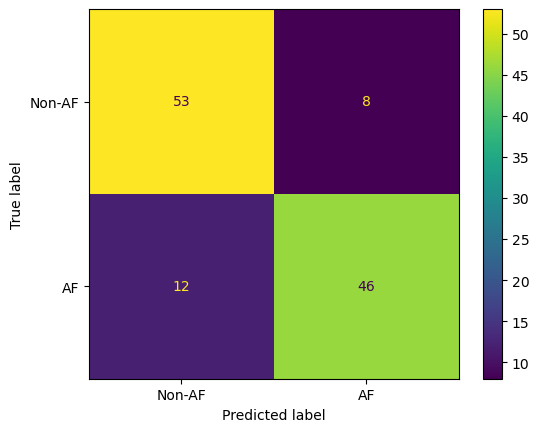

: 

In [104]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from copy import copy
import numpy as np
cm = confusion_matrix(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1))
cm=np.array([[53,8],[12,46]])
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()
F1=2*TP/(2*TP+FP+FN)
print(F'f1score={F1:.8f}')